## 基于TensorFlow+CNN实现猫狗识别

+ 推荐论文：《Deep Residual Learning for Image Recognition》，Kaiming He, et al，介绍VGG和残差网络的对比及改进
+ 残差神经网络：添加新的网络层结构，并与没有添加的对比，保留更好的结果，可保证添加网络层后结果不比原来差

### 5 迁移学习：
+ 迁移学习：使用模型相同、数据维度相同，目标尽可能相同时使用。相当于借鉴一个较好模型的权重参数，用在新的模型上
+ 基本策略主要有两个：
+ （1）利用训练好的模型的权重参数作为初始化参数，在该基础上继续训练，一般全连接层需要自己训练，可选择是否训练已经训练好的特征提取层
+ （2）直接利用已训练好的参数，此时通常将卷积层保持不变或微调，只改变全连接层部分。根据数据集的大小自行调整卷积层不变范围，数据集越大，不变范围越小（一般开始不变，后边改变）
+ Tensorflow的官网中tensorflow.keras.applications有已经训练好的模型，如：from tensorflow.keras.applications.resnet import ResNet50
+ Tensorflow的官网链接：https://tensorflow.google.cn/api_docs/python/tf/keras/applications/resnet_rs/ResNetRS101
+ 回调函数callback的使用：相当于一个监视器，在训练过程中设置一些自定义项，比如提前停止、改变学习率等
+ 结果比较差，准确率较低

##### 5.1 指定数据路径（训练集和验证集）

In [9]:
import os
import warnings
warnings.filterwarnings ("ignore")   # 忽略警告消息
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers   # 更高层次封装API，方便使用
from tensorflow.keras import Model   # 导入模型块

# 数据文件夹
base_dir = './data1/'
train_dir = os.path.join(base_dir, 'train/')
validation_dir = os.path.join(base_dir, 'validation/')

# 训练集
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# 测试集
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

##### 5.2 数据预处理

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range = 40, width_shift_range = 0.2,
                                   height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2,
                                   horizontal_flip = True)   # 归一化图像，加入数据增强
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(   # 训练生成器
    train_dir,   # 文件夹路径
    batch_size = 20,   # 小批量大小
    class_mode = 'binary',   # 二分类用binary，多分类用categorical
    target_size = (75, 75)
)

validation_generator = test_datagen.flow_from_directory(   # 测试生成器
    validation_dir,   # 文件夹路径
    batch_size = 20,   # 小批量大小
    class_mode = 'binary',   # 二分类用binary，多分类用categorical
    target_size = (75, 75),   # 指定resize成的大小
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


##### 5.3. 构建卷积神经网络（导入模型）
+ 导入一般比较慢，建议用迅雷自行下载
+ 导入后存放在：C盘\用户\administator\.keras文件中
+ 导入较慢，网络可能出现问题而报错，多运行几次就好啦

In [14]:
from tensorflow.keras.applications.resnet import ResNet101   # 迁移学习ResNet101网络

pre_trained_model = ResNet101(input_shape = (75, 75, 3),   # 输入大小，考虑说明要求设置>32
                              include_top = False,   # 不要最后的全连接层
                              weights = 'imagenet')   #  在ImageNet上预训练
for layer in pre_trained_model.layers:
    layer.trainable = False   # 不改变训练层

171446536/171446536 [==============================] - 9s 0us/step


##### 5.4 构建卷积神经网络（定义callback）
+ callbacks = [
+    tf.keras.callbacks.EarlyStoppong(patience = 2, monitor = 'val_loss'),   # 如果连续两个epoch还没降低就停止
+    tf.keras.callbacks.LearningRateScheduler   # 动态改变学习率
+    tf.keras.callbacks.ModelCheckpoint   # 保存模型
+    tf.keras.callbacks.Callback   # 自定义方法
+ ]

In [15]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if(logs.get('acc') > 0.95):   # 准确率大于0.95则停止
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True

x = layers.Flatten()(pre_trained_model.output)   # 为全连接层准备
x = layers.Dense(1024, activation='relu')(x)   # 加入全连接层，需要重头训练
x = layers.Dropout(0.2)(x)   # 防止过拟合
x = layers.Dense(1, activation='sigmoid')(x)   # 输出层二值函数
model = Model(pre_trained_model.input, x)   # 构建模型序列
model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'binary_crossentropy', metrics = ['acc'])   # 配置训练器

##### 5.5 训练网络模型（加入callback模块）

In [17]:
callback = myCallback()
history = model.fit(
    train_generator,
    steps_per_epoch = 100,   # 数据量/批量大小=批次
    epochs = 100,   # 迭代次数
    validation_data = validation_generator,
    validation_steps = 50,   # 数据量/批量大小=批次
    verbose = 2,
    callbacks = [callback],
)

Epoch 1/100
100/100 - 78s - loss: 1.1506 - acc: 0.5065 - val_loss: 0.6685 - val_acc: 0.5990 - 78s/epoch - 777ms/step
Epoch 2/100
100/100 - 72s - loss: 0.7152 - acc: 0.5080 - val_loss: 0.6853 - val_acc: 0.5050 - 72s/epoch - 715ms/step
Epoch 3/100
100/100 - 69s - loss: 0.6878 - acc: 0.5485 - val_loss: 0.6736 - val_acc: 0.5930 - 69s/epoch - 686ms/step
Epoch 4/100
100/100 - 72s - loss: 0.6913 - acc: 0.5305 - val_loss: 0.6825 - val_acc: 0.5790 - 72s/epoch - 717ms/step
Epoch 5/100
100/100 - 70s - loss: 0.6887 - acc: 0.5450 - val_loss: 0.6765 - val_acc: 0.5750 - 70s/epoch - 697ms/step
Epoch 6/100
100/100 - 69s - loss: 0.6842 - acc: 0.5665 - val_loss: 0.6697 - val_acc: 0.5960 - 69s/epoch - 695ms/step
Epoch 7/100
100/100 - 71s - loss: 0.6809 - acc: 0.5720 - val_loss: 0.6909 - val_acc: 0.5250 - 71s/epoch - 708ms/step
Epoch 8/100
100/100 - 71s - loss: 0.6873 - acc: 0.5515 - val_loss: 0.6722 - val_acc: 0.5810 - 71s/epoch - 711ms/step
Epoch 9/100
100/100 - 71s - loss: 0.6832 - acc: 0.5575 - val_los

##### 5.6 效果展示

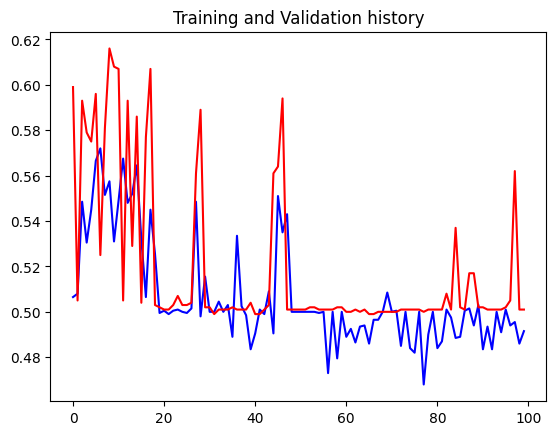

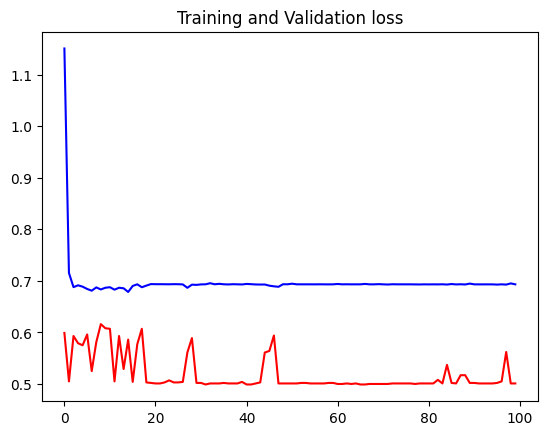

<Figure size 640x480 with 0 Axes>

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and Validation history')
plt.figure()

plt.plot(epochs, loss, 'b', label = 'Training Loss')
plt.plot(epochs, val_acc, 'r', label = 'Validation Loss')
plt.title('Training and Validation loss')
plt.figure()

plt.show()